In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import timm
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
DF_PATH = "../data/train.csv"

df = pd.read_csv(DF_PATH)
df.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,0.117484,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.389315,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,8.552908,0.395241,2.343153,1130.096731,NaN,NaN,NaN,NaN,NaN,NaN
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,1.083629,0.154200,1.155308,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,0.657585,10.919966,2.246226,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899


In [3]:
no_preprocessing_columns = list(filter(lambda x: x.startswith("X"), df.columns))
no_preprocessing_columns.extend(["id", ])
preprocessing_columns = [item for item in df.columns if item not in no_preprocessing_columns]

scaler = StandardScaler()
scaler.fit(df[preprocessing_columns])

df[preprocessing_columns] = scaler.transform(df[preprocessing_columns])
df.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
0,192027691,-0.308725,-0.889802,-0.554512,0.490021,0.805016,0.879735,0.460272,0.579818,0.487341,...,0.117484,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
1,195542235,0.355134,-1.259414,-0.936992,-0.583946,1.075379,1.615380,0.403478,0.248144,0.612104,...,0.389315,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477
2,196639184,-0.042541,-0.203696,-0.648946,-1.225982,-0.412910,-0.264452,-0.562008,-0.481537,-0.573140,...,8.552908,0.395241,2.343153,1130.096731,NaN,NaN,NaN,NaN,NaN,NaN
3,195728812,0.541083,0.539961,0.182802,-0.369732,-0.434778,-0.523488,0.176305,-0.614206,-0.198852,...,1.083629,0.154200,1.155308,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187
4,195251545,-1.833272,-0.687428,-0.640040,-0.583637,2.541933,2.258165,-1.470702,0.380814,-0.510759,...,0.657585,10.919966,2.246226,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899


In [4]:
input_columns = list(filter(lambda x: not (x.endswith("mean") or x.endswith("sd") or x == "id"), df.columns))
output_columns = list(filter(lambda x: x.endswith("mean"), df.columns))

df[input_columns].head()

,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
0,-0.308725,-0.889802,-0.554512,0.490021,0.805016,0.879735,0.460272,0.579818,0.487341,0.633997,...,0.638743,0.927605,1.040217,0.817117,0.347126,0.213268,0.384477,0.644727,0.544614,0.236286
1,0.355134,-1.259414,-0.936992,-0.583946,1.075379,1.615380,0.403478,0.248144,0.612104,0.505870,...,-0.768723,-0.881663,-0.942067,-1.069347,-1.022200,-1.020704,-0.940234,-0.787698,-0.648572,-0.492379
2,-0.042541,-0.203696,-0.648946,-1.225982,-0.412910,-0.264452,-0.562008,-0.481537,-0.573140,-0.583211,...,0.488973,0.413616,0.405373,0.406568,0.344944,0.294744,0.386658,0.516051,0.623689,0.651859
3,0.541083,0.539961,0.182802,-0.369732,-0.434778,-0.523488,0.176305,-0.614206,-0.198852,-0.262893,...,-0.321266,-0.438934,-0.559986,-0.635205,-0.534976,-0.460638,-0.527141,-0.260902,-0.219068,-0.193552
4,-1.833272,-0.687428,-0.640040,-0.583637,2.541933,2.258165,-1.470702,0.380814,-0.510759,0.185552,...,-0.128926,0.260018,0.553307,1.199778,1.516921,1.560907,1.258588,0.767458,0.616531,0.594171


In [5]:
df[output_columns].head()

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
0,0.401753,11.758108,0.117484,1.243779,1.849375,50.216034
1,0.480334,15.748846,0.389315,0.642940,1.353468,574.098472
2,0.796917,5.291251,8.552908,0.395241,2.343153,1130.096731
3,0.525236,9.568305,1.083629,0.154200,1.155308,1042.686546
4,0.411821,14.528877,0.657585,10.919966,2.246226,2386.467180


In [6]:
df_sample = df.sample(n=5000, ignore_index=True, random_state=42)

In [7]:
df_train, df_valid = train_test_split(df_sample, random_state=42, test_size=.2)

df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [8]:
from albumentations.pytorch import ToTensorV2

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
IMG_SIZE = 224

train_transforms = A.Compose([
     A.Resize(width=IMG_SIZE, height=IMG_SIZE),
    A.ToFloat(),
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
    ToTensorV2()
])

valid_transforms = A.Compose([
     A.Resize(width=IMG_SIZE, height=IMG_SIZE),
    A.ToFloat(),
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
    ToTensorV2()
])

In [9]:
from torch.utils.data import Dataset, DataLoader

class PlantDatasetTrain(Dataset):
    def __init__(self, df, input_columns, output_columns, images_path, transforms):
        self.df = df
        self.input_columns = input_columns
        self.output_columns = output_columns
        self.images_path = images_path
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_id = self.df.loc[index, "id"]
        image_name = f"{image_id}.jpeg"
        image_path = f"{self.images_path}/{image_name}"
        
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)["image"]
        #image = np.transpose(image, (2, 0, 1))
        
        input_columns_data = self.df.loc[index, self.input_columns].values.astype(np.float32)
        output_columns_data = self.df.loc[index, self.output_columns].values.astype(np.float32)
        
        return image, input_columns_data, output_columns_data
    
class PlantDatasetValid(Dataset):
    def __init__(self, df, input_columns, output_columns, images_path, transforms):
        self.df = df
        self.input_columns = input_columns
        self.output_columns = output_columns
        self.images_path = images_path
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_id = self.df.loc[index, "id"]
        image_name = f"{image_id}.jpeg"
        image_path = f"{self.images_path}/{image_name}"
        
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)["image"]
        #image = np.transpose(image, (2, 0, 1))
        
        input_columns_data = self.df.loc[index, self.input_columns].values.astype(np.float32)
        output_columns_data = self.df.loc[index, self.output_columns].values.astype(np.float32)
        
        return image, input_columns_data, output_columns_data

In [10]:
train_dataset = PlantDatasetTrain(df_train, input_columns, output_columns, images_path="data/train_images", transforms=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=1)

valid_dataset = PlantDatasetValid(df_valid, input_columns, output_columns, images_path="data/train_images", transforms=valid_transforms)
valid_dataloader = DataLoader(valid_dataset, batch_size=1)

In [11]:
class Backbone(nn.Module):
    def __init__(self, backbone_name, output_size):
        super(Backbone, self).__init__()
        self.backbone_name = backbone_name
        self.output_size = output_size
        self.model = timm.create_model(self.backbone_name, pretrained=True)
        
        self.model.classifier = nn.Linear(1280, self.output_size)
        
    def forward(self, X):
        return self.model(X)
    
backbone_model = Backbone("efficientnet_b0", 256).to(device)

In [12]:
class IntermediateModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(IntermediateModel, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        if self.hidden_sizes is None:
            self.model = nn.Linear(self.input_size, self.output_size)
        else:
            self.model = nn.ModuleList()
            self.model.append(nn.Linear(self.input_size, self.hidden_sizes[0]))
            for i in range(len(self.hidden_sizes) - 1):
                self.model.append(nn.Linear(self.hidden_sizes[i], self.hidden_sizes[i+1]))
            self.model.append(nn.Linear(self.hidden_sizes[-1], self.output_size))
            
        self.relu = nn.ReLU()
        
    def forward(self, X):
        for layer in self.model:
            X = self.relu(layer(X))
            
        return X
    
intermediate_model = IntermediateModel(163, 32, [64, ]).to(device)

In [13]:
class CombinedModel(nn.Module):
    def __init__(self, backbone, intermediate_model, backbone_size, intermediate_size, output_size):
        super(CombinedModel, self).__init__()
        
        self.backbone = backbone
        self.intermediate_model = intermediate_model
        self.backbone_size = backbone_size
        self.intermediate_size = intermediate_size
        self.output_size = output_size
        
        combined_input_size = self.backbone_size + self.intermediate_size
        self.model = nn.Linear(combined_input_size, self.output_size)
        #self.relu = nn.ReLU()
        
    def forward(self, images, X):
        images = self.backbone(images)
        X = self.intermediate_model(X)
        
        cat_X = torch.cat((images, X), dim=1)
        #cat_X = self.relu(cat_X)
        
        return self.model(cat_X)
    
model = CombinedModel(backbone_model, intermediate_model, 256, 32, 6).to(device)

In [15]:
import torch.optim as optim

EPOCHS = 10
LR = 1e-4

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [16]:
def train(model, dataloader, optimizer, loss_fn, epoch):
    model.train()
    running_mse_loss = 0.
    
    loop = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Training - Epoch[{epoch}/{EPOCHS}]")
    
    for batch_idx, (images, X, y) in loop:
        images = images.to(device)
        X = X.to(device)
        y = y.to(device)
        
        prediction = model(images, X)
        loss = loss_fn(prediction, y)
        loss_value = loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_mse_loss += loss_value * images.size(0)
        
        loop.set_postfix(loss=loss_value)
        
    return running_mse_loss / len(dataloader.dataset)

In [17]:
def valid(model, dataloader, loss_fn, epoch):
    model.eval()
    running_mse_loss = 0.
    
    loop = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Validation - Epoch[{epoch}/{EPOCHS}]")
    
    with torch.inference_mode():
        for batch_idx, (images, X, y) in loop:
            images = images.to(device)
            X = X.to(device)
            y = y.to(device)
            
            prediction = model(images, X)
            loss = loss_fn(prediction, y)
            loss_value = loss.item()
            
            running_mse_loss += loss_value * images.size(0)
            
            loop.set_postfix(loss=loss_value)
            
    return running_mse_loss / len(dataloader.dataset)

In [19]:
train_losses = []
valid_losses = []

for epoch in range(1, EPOCHS+1):
    train_epoch_loss = train(model, train_dataloader, optimizer, loss_fn, epoch)
    train_losses.append(train_epoch_loss)
    
    valid_epoch_loss = valid(model, valid_dataloader, loss_fn, epoch)
    valid_losses.append(valid_epoch_loss)

Validation - Epoch[10/10]: 100%|█████████████████████████████████| 1000/1000 [00:10<00:00, 93.88it/s, loss=5.34e+5]


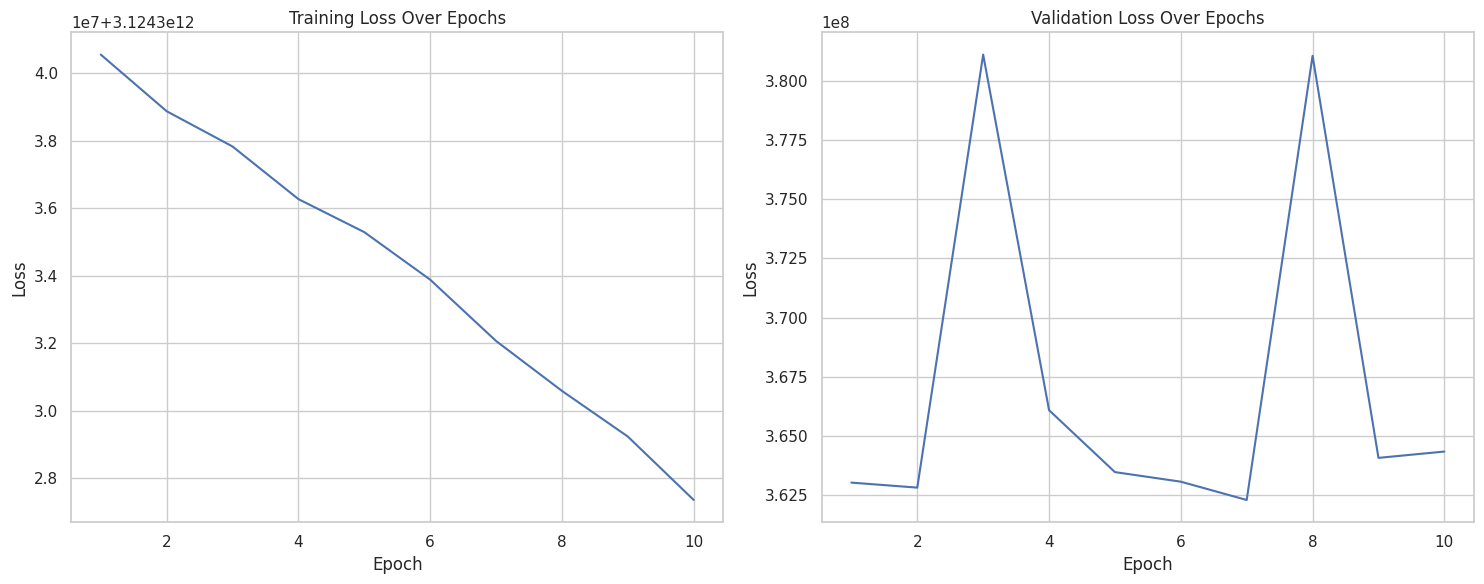

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x=epochs, y=train_losses, ax=axes[0])
axes[0].set_title('Training Loss Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

sns.lineplot(x=epochs, y=valid_losses, ax=axes[1])
axes[1].set_title('Validation Loss Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

plt.tight_layout()

plt.show()

Well that's not good 😬